In [8]:
import numpy as np
import os
import random

from matplotlib import pyplot as plt
import cv2

from sklearn.model_selection import train_test_split

import keras
import tensorflow as tf

from keras.models import Sequential, Model
from keras.models import load_model

from keras.applications.vgg16 import VGG16
 
from keras.layers import Flatten
from keras.layers import Flatten, Conv2D, MaxPooling2D, Dense, Concatenate, Dot, Lambda, Input

from keras.callbacks import History 

from tensorflow.keras import initializers
from tensorflow.keras.regularizers import l2

from keras.optimizers import Adam
from keras import backend as K

from sklearn.utils import shuffle

import h5py

In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.config.experimental.list_physical_devices('GPU')
tf.test.gpu_device_name()

Num GPUs Available:  1


'/device:GPU:0'

create a dictionary mapping each missile model to their corresponding samples' filenames

In [9]:
missile_dir = r'C:\Users\Admin\few_shot_learning\main\data\missile'
missiles = os.listdir(missile_dir)
all_imgs_dir = {}

for missile in missiles:
    imgs_dir = r'{}\{}'.format(missile_dir, missile)
    imgs = os.listdir(imgs_dir)
    imgs = [r'{}\{}'.format(imgs_dir, fn.strip()) for fn in imgs]
    all_imgs_dir.update({missile : imgs})

print(missiles)

['aster', 'ihawk', 'spyder']


In [10]:
uav_dir = r'C:\Users\Admin\few_shot_learning\main\data\uav'
uavs = os.listdir(uav_dir)

for uav in uavs:
    imgs_dir = r'{}\{}'.format(uav_dir, uav)
    imgs = os.listdir(imgs_dir)
    imgs = [r'{}\{}'.format(imgs_dir, fn.strip()) for fn in imgs]
    all_imgs_dir.update({uav : imgs})

    print(uav)

hermes
heron


In [11]:
print(list(all_imgs_dir.keys()))
print(all_imgs_dir['aster'][0])

['aster', 'ihawk', 'spyder', 'hermes', 'heron']
C:\Users\Admin\few_shot_learning\main\data\missile\aster\2Q__ (1).jpg


In [12]:
def pad_img(img, desired_ratio):
    height = img.shape[0]
    width = img.shape[1]

    try:
    
        channels = img.shape[2]

    except IndexError:
        # img is a single channel image -> convert to rgb space
        img = cv2.merge((img,img,img))
    
    if img.shape[2] == 4:
        # img has alpha channel -> convert to rgb space
        img = cv2.cvtColor(img, cv2.COLOR_BGRA2BGR)

    aspect_ratio = width / height

    if aspect_ratio > desired_ratio:
        # image is too 'long' -> pad the top and bottom
        required_height = width / desired_ratio
        required_padding = int((required_height - height) // 2)
        
        padded_img = cv2.copyMakeBorder(img, top = required_padding, bottom = required_padding, left = 0, right = 0, borderType = cv2.BORDER_CONSTANT)

    elif aspect_ratio < desired_ratio:
        # image is too 'tall' -> pad the sides
        required_width = height * desired_ratio
        required_padding = int((required_width - width) // 2)
        
        padded_img = cv2.copyMakeBorder(img, top = 0, bottom = 0, left = required_padding, right = required_padding, borderType = cv2.BORDER_CONSTANT)
    else:
        # image is perfect ratio -> no padding required
        return img

    return padded_img

def pad_and_resize(img, desired_ratio, width, height):

    padded_img = pad_img(img, desired_ratio)
    result = cv2.resize(padded_img, (width, height))
    return result


Test the above function!

(194, 259, 3)
(200, 280, 3)
<class 'numpy.ndarray'>


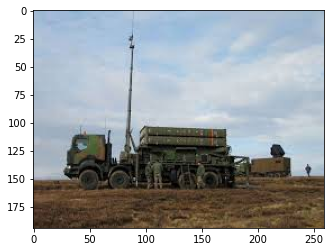

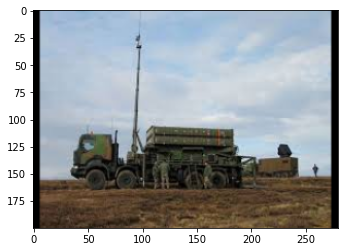

In [13]:
img = plt.imread(all_imgs_dir['aster'][5])
plt.figure()
plt.imshow(img)
print(img.shape)

plt.figure()
new_img = pad_and_resize(img, desired_ratio=1.4, width=280, height=200)
plt.imshow(new_img)
print(new_img.shape)
print(type(new_img))

simple, unscientific scan of the common aspect ratios in our dataset reveals that most images have 1.5 ratio

In [7]:
ratios = []
widths = []
heights = []
for missile, imgs in all_imgs_dir.items():
    for im in imgs:
        img  = plt.imread(im)
        ratios.append(img.shape[1]/img.shape[0])
        widths.append(img.shape[1])
        heights.append(img.shape[0])

print(sum(ratios)/ len(ratios))
print(sum(widths)/ len(widths))
print(sum(heights)/ len(heights))



1.570266643508157
362.22392026578075
236.2498338870432


In [14]:
def save_data(path='preprocess/', **kwargs):
    # save it once to allow load from file

    # train_pairs, train_labels and X_test all contain 0s and 1s which can be converted to unsigned 8 bit ints
    # use np.astype(np.uint8) to convert array before saving

    print('saving data...')
    for key, value in kwargs.items():

        with h5py.File('{}{}.h5'.format(path, key), 'w') as hf:

           if type(value).__module__ == np.__name__:

                # train_pairs and X_test are image sets which are just 0s and 1s
                # train_labels also contain only 0s and 1s which 
                # can be converted to unsigned 8 bit ints
                # use np.astype(np.uint8) to convert array before saving

                value = value.astype(np.uint8)
                hf.create_dataset(key, value.shape, h5py.h5t.STD_U8BE, data = value)
                
                print('saved {} to /{}{}.h5!'.format(key, path, key))

           else:

                # If data is a list of strings
                dt = h5py.special_dtype(vlen=str) 
                value = np.array(value, dtype=dt) 
                hf.create_dataset(key, data = value)

                print('saved {} to /{}{}.h5!'.format(key, path, key))
            
    
    return None

#load from file
def load_data(path='preprocess/', **kwargs):

    all_data = {}

    for key, value in kwargs.items():
     
        if value:

            with h5py.File('{}{}.h5'.format(path, key), 'r') as hf:

                if type(hf[key][0]) == bytes:
             
                    data = [item.decode('utf8') for item in hf[key][:]] # convert from bytes to str
                else:
                    data = hf[key][:]

                all_data.update({key : data}) 
                print('{} loaded from /{}{}.h5!'.format(key, path, key))

    return all_data

convert all our images into 3 channel images with padding (if needed) and resized to our desired dimensions

In [15]:
def get_all_X_Y(all_imgs_dir, desired_ratio, width, height):
    
    X = np.array([])
    Y = []
    count = 0

    for label, fns in all_imgs_dir.items():
        for fn in fns:
            img = plt.imread(fn)
            new_img = pad_and_resize(img, desired_ratio, width, height)
        
            if X.size == 0:
                X = np.array([new_img])
                Y.append(label)
                continue

            try:
                X = np.vstack((X, [new_img]))
                Y.append(label)  

            except Exception as e:
                print(e)
                print(fn)
            
            if count % 200 == 0:
                print(count)

            count += 1
    
    return X.astype("int"), Y

In [9]:
# X, Y = get_all_X_Y(all_imgs_dir, desired_ratio=1.4, width=280, height=200)

In [10]:
# print(X.shape, len(Y))

In [21]:
# save_data(path=r"D://", X=X, Y=Y)
# save_data(path=r"D://", all_pairs=all_pairs)
# save_data(path=r"D://", all_labels=all_labels, all_raw_labels=pos_raw_labels)
# save_data(all_pairs=all_pairs)
save_data(all_labels=all_labels)
save_data(all_raw_labels=all_raw_labels.tolist())

saving data...
saved all_labels to /preprocess/all_labels.h5!
saving data...
saved all_raw_labels to /preprocess/all_raw_labels.h5!


In [16]:
kwargs = {'X' : False,
          # 'Y' : True,
          # 'all_pairs' : True,
          # 'all_labels' : True,
          # 'all_raw_labels' : True,
          'train_pairs' : True,
          'train_labels' : True,
          'val_pairs' : True,
          'val_labels' : True
          # 'test_pairs': True,
          # 'test_labels' : True
        
        }
        
data = load_data(**kwargs)

train_pairs loaded from /preprocess/train_pairs.h5!
train_labels loaded from /preprocess/train_labels.h5!
val_pairs loaded from /preprocess/val_pairs.h5!
val_labels loaded from /preprocess/val_labels.h5!


In [17]:
# all_pairs = data['all_pairs']
# all_labels = data['all_labels']
# all_raw_labels = data['all_raw_labels']
train_pairs = data['train_pairs']
train_labels = data['train_labels']
val_pairs = data['val_pairs']
val_labels = data['val_labels']
# X = data['X']
# Y = data['Y']
data = 0

In [13]:
all_pairs.shape

(20535, 2, 200, 280, 3)

In [12]:
def make_pairs(X, Y, unique):

    # this function will produce < 2*len(X) pairs if unique=True as it will not allow the same image to be used twice
    # also if unique=True the # of positive samples most likely != # of negative samples

    pairs = []
    labels = []
    raw_labels = []
    chosen_j = []

    if unique:
        exclude_j = []

    for i in range(len(X)):
        if i % 100 == 0:
            print(i)
        # choose a matching sample
        x1 = X[i]
        class_ = Y[i]

        # get possible indices where x2 is same class as x1
        if unique:
            J = [j for j, y in enumerate(Y) if y == class_ and not j in exclude_j]
        else:
            J = [j for j, y in enumerate(Y) if y == class_]

        if len(J) != 0:
            

            j = np.random.choice(J)
            chosen_j.append(j)

            if unique:
                exclude_j.append(j)

            x2 = X[j]

            pairs += [[x1, x2]]
            labels += [1]

            raw_labels += [[Y[i], Y[j]]]

        # get non-match
        # get possible indices where x2 is different from x1
        if unique:
            J = [j for j, y in enumerate(Y) if y != class_ and not j in exclude_j]
        else:
            J = [j for j, y in enumerate(Y) if y != class_]

        if len(J) != 0:
            

            j = np.random.choice(J)
            chosen_j.append(j)

            if unique:
                exclude_j.append(j)

            x2 = X[j]

            pairs += [[x1, x2]]
            labels += [0]
            raw_labels += [[Y[i], Y[j]]]
        
    return np.array(pairs), np.array(labels), np.array(raw_labels), chosen_j

In [13]:
def make_positive_pairs(X, Y, classes, N):

    # this function will produce N pairs of positive samples

    from itertools import combinations

    pairs = []
    labels = []
    raw_labels = []

    for label in classes:
        print(label)
        pos_i = [i for i, y in enumerate(Y) if y == label]
        comb = combinations(pos_i, 2)
        for c in comb:
            i = c[0]
            j = c[1]
            x1 = X[i]
            x2 = X[j]
            pairs += [[x1, x2]]
            labels += [1]
            raw_labels += [[Y[i], Y[j]]]

    pairs, labels, raw_labels = shuffle(pairs, labels, raw_labels)
        
    return np.array(pairs[:N]), np.array(labels[:N]), raw_labels[:N]

In [14]:
def make_negative_pairs(X, Y, N):

    # this function will produce N pairs of positive samples
    
    import math


    pairs = []
    labels = []
    raw_labels = []

    pairs_per_img = math.ceil(N/len(X))

    for i in range(len(X)):
        if i % 100 == 0:
                print(i)
        for k in range(pairs_per_img):
                        
            x1 = X[i]
            class_ = Y[i]

            # get non-match
        
            J = [j for j, y in enumerate(Y) if y != class_]

            j = np.random.choice(J)
        
            x2 = X[j]

            pairs += [[x1, x2]]
            labels += [0]
            raw_labels += [[Y[i], Y[j]]]
        
    pairs, labels, raw_labels = shuffle(pairs, labels, raw_labels)
        
    return np.array(pairs), np.array(labels), raw_labels

In [28]:
pos_pairs, pos_labels, pos_raw_labels = make_positive_pairs(X, Y, list(all_imgs_dir.keys()), N=10000)

aster
ihawk
spyder
hermes
heron


In [29]:
print(pos_pairs.shape)
print(pos_labels.shape)
print(len(pos_raw_labels))

(10000, 2, 200, 280, 3)
(10000,)
10000


In [30]:
neg_pairs, neg_labels, neg_raw_labels = make_negative_pairs(X, Y, N=10000)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500


In [31]:
neg_pairs.shape

(10535, 2, 200, 280, 3)

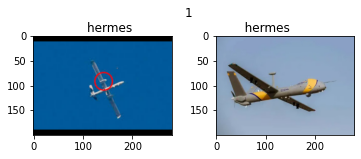

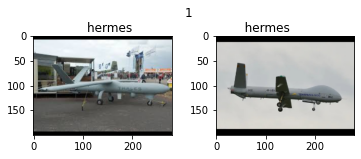

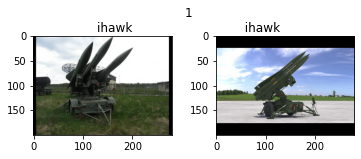

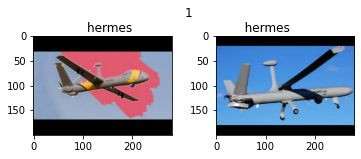

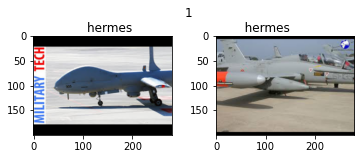

In [32]:
for i in range(5):
    
    fig = plt.figure()
    rand_i = np.random.randint(0, len(pos_labels))
    fig.suptitle('{}\n{}                             {}'.format(pos_labels[rand_i], pos_raw_labels[rand_i][0], pos_raw_labels[rand_i][1]))
    plt.subplot(2,2,1)
    plt.imshow(pos_pairs[rand_i][0])
    plt.subplot(2,2,2)
    plt.imshow(pos_pairs[rand_i][1])

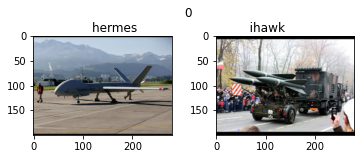

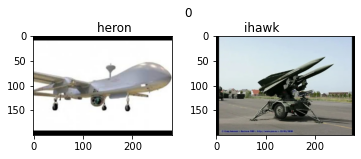

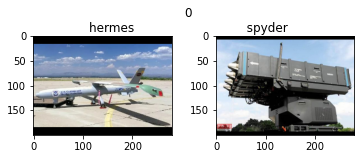

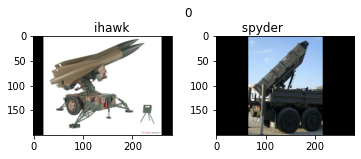

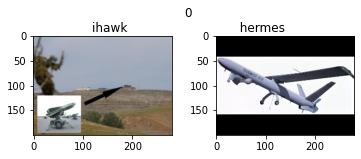

In [33]:
for i in range(5):
    
    fig = plt.figure()
    rand_i = np.random.randint(0, len(neg_labels))
    fig.suptitle('{}\n{}                             {}'.format(neg_labels[rand_i], neg_raw_labels[rand_i][0], neg_raw_labels[rand_i][1]))
    plt.subplot(2,2,1)
    plt.imshow(neg_pairs[rand_i][0])
    plt.subplot(2,2,2)
    plt.imshow(neg_pairs[rand_i][1])

In [38]:
all_pairs = np.vstack((pos_pairs, neg_pairs))

In [20]:
all_labels = np.append(pos_labels, neg_labels)
all_labels.shape

(20535,)

In [35]:
all_raw_labels = pos_raw_labels.extend(neg_raw_labels)[:]
len(all_raw_labels)

20535

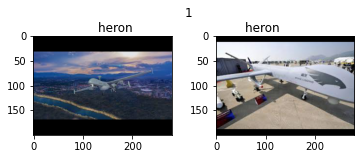

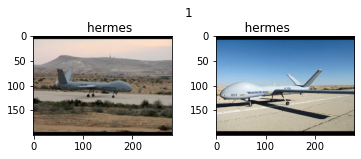

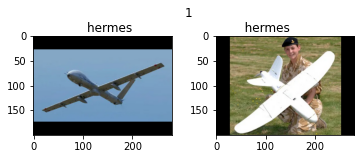

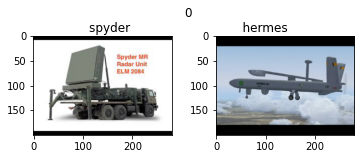

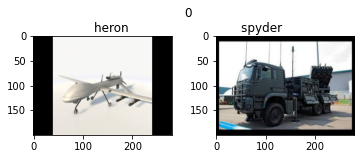

In [25]:
for i in range(5):
    
    fig = plt.figure()
    rand_i = i
    # rand_i = np.random.randint(0, len(all_labels))
    fig.suptitle('{}\n{}                             {}'.format(all_labels[rand_i], all_raw_labels[rand_i][0], all_raw_labels[rand_i][1]))
    plt.subplot(2,2,1)
    plt.imshow(all_pairs[rand_i][0])
    plt.subplot(2,2,2)
    plt.imshow(all_pairs[rand_i][1])

In [16]:
all_pairs, all_labels, all_raw_labels = shuffle(all_pairs, all_labels, all_raw_labels)

In [18]:
def get_pretrained_model(input_shape):
    """
        Model architecture
    """

    # Define the tensors for the two input images
    left_input = Input(input_shape)
    right_input = Input(input_shape)

    # Convolutional Neural Network
    pre_train = Sequential()
    base = VGG16(include_top=False, input_shape=input_shape)
  
    # freeze all layers but last 4
    for layer in base.layers[:-4]:
        layer.trainable = False

    for layer in base.layers:
        print(layer.name, layer.trainable)
    
    pre_train.add(base)
    pre_train.add(tf.keras.layers.Flatten())
    pre_train.add(Dense(256))
    embedding = Model(pre_train.input, pre_train.output, name="Embedding")
    
    

    # Generate the encodings (feature vectors) for the two images
    encoded_l = embedding(left_input)
    encoded_r = embedding(right_input)
    
 
    # Add a customized layer to compute the absolute difference between the encodings
    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])
  

    # # Add a dense layer with a sigmoid unit to generate the similarity score
    prediction = Dense(1,activation='sigmoid',bias_initializer='zeros')(L1_distance)


    # # Connect the inputs with the outputs
    pretrained_model = Model(inputs=[left_input,right_input], outputs=prediction)

    # return the model
    return pretrained_model


In [57]:
class EarlyStoppingAtMinLoss(keras.callbacks.Callback):
    """Stop training when the loss is at its min, i.e. the loss stops decreasing.

  Arguments:
      patience: Number of epochs to wait after min has been hit. After this
      number of no improvement, training stops.
  """

    def __init__(self, val_inputs, val_labels, patience=0):
        super(EarlyStoppingAtMinLoss, self).__init__()
        self.patience = patience
        # best_weights to store the weights at which the minimum loss occurs.
        self.best_weights = None
        self.best_epoch = 0
        self.val_inputs = val_inputs
        self.val_labels = val_labels

    def on_train_begin(self, logs=None):
        # The number of epoch it has waited when loss is no longer minimum.
        self.wait = 0
        # The epoch the training stops at.
        self.stopped_epoch = 0
        # Initialize the best as infinity.
        self.best = np.Inf

    def on_epoch_begin(self, epoch, logs=None):
        if epoch != 0:
            print('\n\n')

    def on_epoch_end(self, epoch, logs=None):
        
        print('\nEvaluating model on validations set')
        metrics = self.model.evaluate(x=self.val_inputs, y=self.val_labels, batch_size=16, verbose=1, sample_weight=None, steps=None, return_dict = True)
        current = metrics['loss']

        # for plotting learning process
      
        logs['val_loss'] = metrics['loss']
        logs['val_acc'] = metrics['accuracy']

        if np.less(current, self.best):
            self.best = current
            self.wait = 0
            self.best_epoch = epoch + 1
            # Record the best weights if current results is better (less).
            self.best_weights = self.model.get_weights()
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                self.model.stop_training = True
                print("Restoring model weights from the end of the best epoch - epoch {}.".format(self.best_epoch))
                self.model.set_weights(self.best_weights)

    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
            print("Epoch {}: early stopping".format(self.stopped_epoch + 1))
        else:
            self.model.set_weights(self.best_weights)
            print("set weights from epoch {}".format(self.best_epoch))
        

split our dataset twice to get training, testing and validation sets

In [28]:
all_train_pairs, test_pairs, all_train_labels, test_labels = train_test_split(all_pairs, all_labels, test_size=0.2, random_state=42)

train_pairs, val_pairs, train_labels, val_labels = train_test_split(all_train_pairs, all_train_labels, test_size=0.2, random_state=50)

print(train_pairs.shape, val_pairs.shape, test_pairs.shape)

(13142, 2, 200, 280, 3) (3286, 2, 200, 280, 3) (4107, 2, 200, 280, 3)


In [29]:
# save_data(path=r'D://', train_pairs=train_pairs, train_labels=train_labels)
# save_data(path=r'D://', test_pairs=test_pairs, test_labels=test_labels)
# save_data(path=r'D://', val_pairs=val_pairs, val_labels=val_labels)

save_data(train_pairs=train_pairs, train_labels=train_labels)
save_data(test_pairs=test_pairs, test_labels=test_labels)
save_data(val_pairs=val_pairs, val_labels=val_labels)

saving data...
saved train_pairs to /preprocess/train_pairs.h5!
saved train_labels to /preprocess/train_labels.h5!
saving data...
saved test_pairs to /preprocess/test_pairs.h5!
saved test_labels to /preprocess/test_labels.h5!
saving data...
saved val_pairs to /preprocess/val_pairs.h5!
saved val_labels to /preprocess/val_labels.h5!


In [20]:
model = get_pretrained_model((200, 280, 3))
optimizer = Adam(lr = 0.00009)
model.compile(loss = "binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])


input_3 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_pool True
C:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [21]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200, 280, 3) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 200, 280, 3) 0                                            
__________________________________________________________________________________________________
Embedding (Functional)          (None, 256)          21006400    input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 256)          0           Embedding[0][0]              

In [23]:
val_inputs = [val_pairs[:,0], val_pairs[:,1]]

In [24]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.config.experimental.list_physical_devices('GPU'))

Num GPUs Available:  1


In [56]:
# for plotting metrics of our model's learning process
hist = History()

model.fit([train_pairs[:,0], train_pairs[:,1]], train_labels, batch_size=64, epochs=10, callbacks=[EarlyStoppingAtMinLoss(patience=4, val_inputs=val_inputs, val_labels=val_labels), hist])

Epoch 1/10
206/206 [==============================] - 113s 547ms/step - loss: 0.0499 - accuracy: 0.9849

Evaluating model on validations set
206/206 [==============================] - 27s 130ms/step - loss: 0.2036 - accuracy: 0.9610
Epoch 2/10



206/206 [==============================] - 115s 560ms/step - loss: 0.0454 - accuracy: 0.9893

Evaluating model on validations set
206/206 [==============================] - 27s 133ms/step - loss: 0.1891 - accuracy: 0.9632
Epoch 3/10



206/206 [==============================] - 117s 567ms/step - loss: 0.0195 - accuracy: 0.9946

Evaluating model on validations set
206/206 [==============================] - 28s 134ms/step - loss: 0.1317 - accuracy: 0.9690
Epoch 4/10



206/206 [==============================] - 117s 569ms/step - loss: 0.0044 - accuracy: 0.9989

Evaluating model on validations set
206/206 [==============================] - 28s 134ms/step - loss: 0.1342 - accuracy: 0.9729
Epoch 5/10



206/206 [==============================] - 11

In [35]:
print(hist1.history)

{'loss': [0.8485798835754395, 0.4080809950828552, 0.27742406725883484, 0.21985790133476257, 0.17074918746948242, 0.12909671664237976, 0.10674528777599335, 0.08013176918029785, 0.06406042724847794, 0.0536600761115551], 'accuracy': [0.6059960722923279, 0.8222492933273315, 0.8805356621742249, 0.9082331657409668, 0.9310607314109802, 0.9495510458946228, 0.9636280536651611, 0.9729873538017273, 0.9813574552536011, 0.9835641384124756], 'epoch': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'val_loss': [0.5382735133171082, 0.3886028528213501, 0.31049561500549316, 0.26640674471855164, 0.2614554762840271, 0.2420700192451477, 0.23018038272857666, 0.22941462695598602, 0.22376985847949982, 0.19438575208187103], 'val_acc': [0.7577601671218872, 0.831101655960083, 0.8676202297210693, 0.8877054452896118, 0.8965307474136353, 0.9129641056060791, 0.923919677734375, 0.926658570766449, 0.9363968372344971, 0.9397443532943726]}


In [58]:
with open('plots/LC_vgg16_dict.txt', 'r') as f:
    contents = f.read()
    hist_dict = eval(contents)
for k, v in hist.history.items():
    hist_dict[k] = (hist_dict[k] + hist.history[k])[:]


In [60]:
print(hist_dict)

{'loss': [0.8485798835754395, 0.4080809950828552, 0.27742406725883484, 0.21985790133476257, 0.17074918746948242, 0.12909671664237976, 0.10674528777599335, 0.08013176918029785, 0.06406042724847794, 0.0536600761115551, 0.04514005035161972, 0.04174591973423958, 0.059601716697216034, 0.06058621034026146, 0.014126919209957123, 0.05835115537047386, 0.047164566814899445, 0.03303324058651924, 0.04106347635388374, 0.06234553083777428, 0.03106462024152279, 0.010962316766381264, 0.007634315174072981, 0.049385592341423035, 0.05217548832297325, 0.049858592450618744, 0.04535453021526337, 0.01949845626950264, 0.004416387993842363, 0.0015327525325119495, 0.0003632720618043095, 0.00024004535225685686, 0.0007982580573298037, 0.03085573948919773, 0.1152861937880516], 'accuracy': [0.6059960722923279, 0.8222492933273315, 0.8805356621742249, 0.9082331657409668, 0.9310607314109802, 0.9495510458946228, 0.9636280536651611, 0.9729873538017273, 0.9813574552536011, 0.9835641384124756, 0.9867600202560425, 0.987292

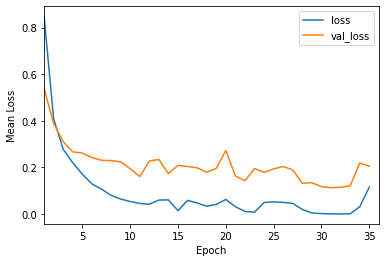

In [68]:

X = range(1, len(hist_dict['loss']) + 1)
for k, v in hist_dict.items():
    if 'loss' in k:
        plt.plot(X, v, label=k)

plt.xlabel('Epoch')
plt.xticks(range(0, len(hist_dict['loss']) + 1, 5))
plt.xlim(X[0], X[-1]+1)

plt.ylabel('Mean Loss')
plt.legend()
plt.savefig('plots/LC_vgg16_missile.pdf')
plt.show()
    

In [64]:
model.save('vgg16_missile_early_stop')

INFO:tensorflow:Assets written to: vgg16_missile_early_stop\assets
INFO:tensorflow:Assets written to: vgg16_missile_early_stop\assets


AttributeError: 'Functional' object has no attribute 'best_weights'